# **Deep Learning for Skin Cancer Detection using CNNs:**

In [ ]:
#import required libraries
import os
import numpy as np
import pandas as pd
import cv2
from collections import Counter
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob
from wolta.visual_tools import crop
import shutil
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import class_weight
from imblearn.over_sampling import RandomOverSampler
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint,  ReduceLROnPlateau
from tensorflow.keras.utils import Sequence

import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)
warnings.simplefilter(action="ignore", category=UserWarning)
warnings.simplefilter(action="ignore", category=RuntimeWarning)
warnings.simplefilter(action='ignore', category=DeprecationWarning)

## EDA

In [ ]:

# Paths to dataset files
data=[
   '/content/HAM10000_Images/vasc',
   '/content/HAM10000_Images/nv',
   '/content/HAM10000_Images/mel',
   '/content/HAM10000_Images/df',
   '/content/HAM10000_Images/bkl',
   '/content/HAM10000_Images/bcc',
   '/content/HAM10000_Images/akiec',
   '/content/HAM10000_Images/bkl',
]


metadata_path='/content/HAM10000_metadata.csv'
images_path= '/content/HAM10000_Images'

#load the metadata csv
metadata=pd.read_csv(metadata_path)
metadata.head(10)

lesion_id      image_id   dx dx_type   age     sex localization
0  HAM_0000118  ISIC_0027419  bkl   histo  80.0    male        scalp
1  HAM_0000118  ISIC_0025030  bkl   histo  80.0    male        scalp
2  HAM_0002730  ISIC_0026769  bkl   histo  80.0    male        scalp
3  HAM_0002730  ISIC_0025661  bkl   histo  80.0    male        scalp
4  HAM_0001466  ISIC_0031633  bkl   histo  75.0    male          ear
5  HAM_0001466  ISIC_0027850  bkl   histo  75.0    male          ear
6  HAM_0002761  ISIC_0029176  bkl   histo  60.0    male         face
7  HAM_0002761  ISIC_0029068  bkl   histo  60.0    male         face
8  HAM_0005132  ISIC_0025837  bkl   histo  70.0  female         back
9  HAM_0005132  ISIC_0025209  bkl   histo  70.0  female         back

In [ ]:
# dictionaries to store statistics
cancer_stats = {
    'total_images': 0,
    'class_distribution': {},
    'image_sizes': [],
    'aspect_ratios': [],
    'mean_intensities': [],
    'std_intensities': [],
    'file_sizes': []
}

# Dictionary to sample images
cancer_samples = {}

In [ ]:
# Analyze Skin Cancer Dataset
print("\n=== Skin Cancer Dataset Analysis ===")
for path in data:
    class_name = os.path.basename(path)
    images_count = 0

    print(f"\nAnalyzing {class_name}...")

    for img_name in os.listdir(path):
        img_path = os.path.join(path, img_name)

        # Read image
        img = cv2.imread(img_path)
        if img is None:
            continue

        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        # Store first image as sample
        if images_count == 0:
            cancer_samples[class_name] = img

        # Update statistics
        cancer_stats['image_sizes'].append(img.shape[:2])
        cancer_stats['aspect_ratios'].append(img.shape[1] / img.shape[0])
        cancer_stats['mean_intensities'].append(np.mean(img))
        cancer_stats['std_intensities'].append(np.std(img))
        cancer_stats['file_sizes'].append(os.path.getsize(img_path) / 1024)  # Size in KB

        images_count += 1

    cancer_stats['class_distribution'][class_name] = images_count
    cancer_stats['total_images'] += images_count



=== Skin Cancer Dataset Analysis ===

Analyzing vasc...

Analyzing nv...

Analyzing mel...

Analyzing df...

Analyzing bkl...

Analyzing bcc...

Analyzing akiec...

Analyzing bkl...


In [ ]:
# Print Basic Statistics
print("\n=== Dataset Summary ===")
print("\nSkin Cancer Dataset:")
print(f"Total images: {cancer_stats['total_images']}")
print("\nClass distribution:")
for class_name, count in cancer_stats['class_distribution'].items():
    percentage = (count/cancer_stats['total_images'])*100
    print(f"{class_name}: {count} images ({percentage:.2f}%)")



=== Dataset Summary ===

Skin Cancer Dataset:
Total images: 11114

Class distribution:
vasc: 142 images (1.28%)
nv: 6705 images (60.33%)
mel: 1113 images (10.01%)
df: 115 images (1.03%)
bkl: 1099 images (9.89%)
bcc: 514 images (4.62%)
akiec: 327 images (2.94%)


## Visualizations


Class Distribution:
 dx
nv       6705
mel      1113
bkl      1099
bcc       514
akiec     327
vasc      142
df        115
Name: count, dtype: int64


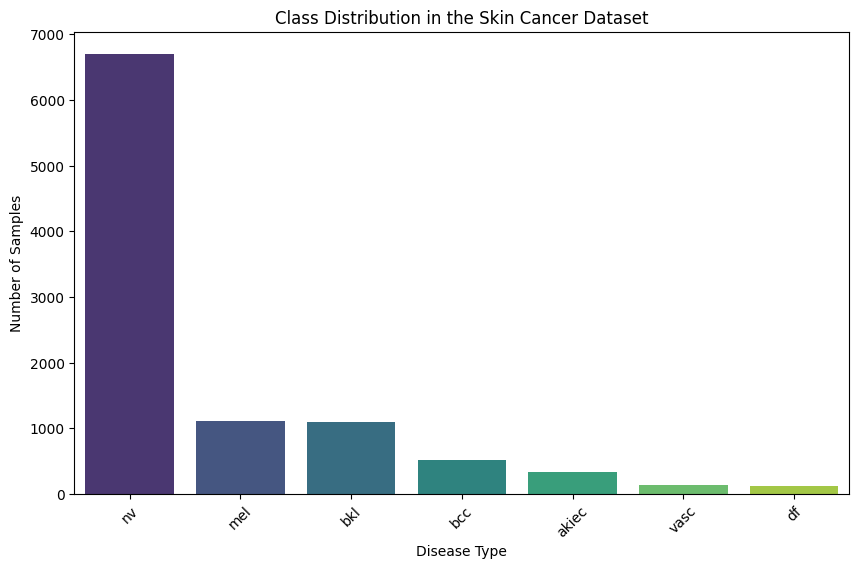

In [ ]:

# Load metadata CSV
metadata = pd.read_csv(metadata_path)

# Class Distribution in Metadata
class_counts = metadata['dx'].value_counts()
print("\nClass Distribution:\n", class_counts)

# Visualize class distribution
plt.figure(figsize=(10, 6))
sns.barplot(x=class_counts.index, y=class_counts.values, palette='viridis')
plt.title('Class Distribution in the Skin Cancer Dataset')
plt.xlabel('Disease Type')
plt.ylabel('Number of Samples')
plt.xticks(rotation=45)
plt.show()

Text(0.5, 1.0, 'The type of medical diagnostics performed')

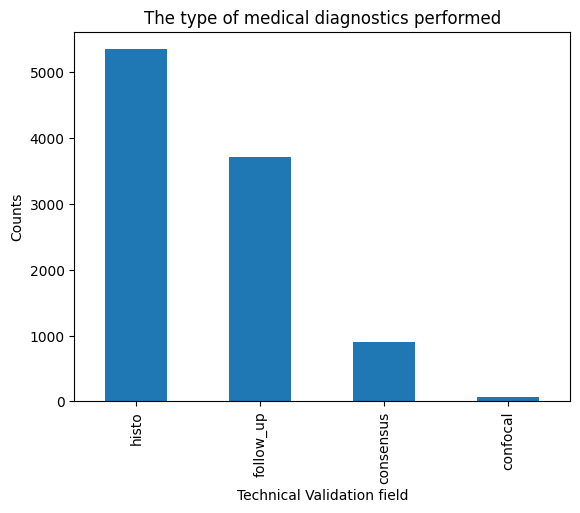

In [ ]:

metadata['dx_type'].value_counts().plot(kind='bar')
plt.xlabel('Technical Validation field')
plt.ylabel('Counts')
plt.title('The type of medical diagnostics performed')

Text(0.5, 1.0, 'The body parts most susceptible for skin cancer')

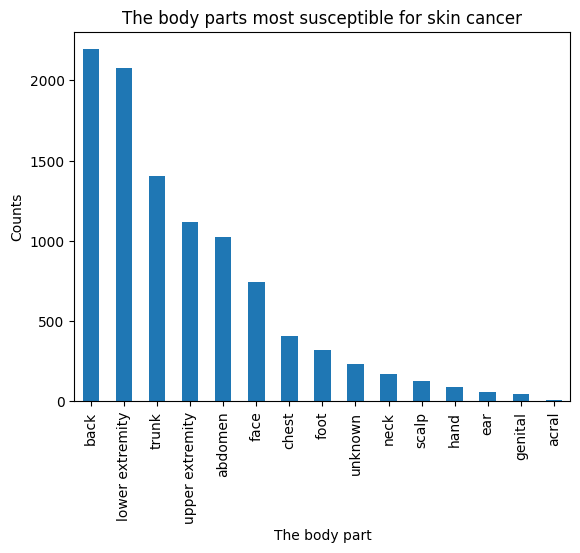

In [ ]:

metadata['localization'].value_counts().plot(kind='bar')
plt.xlabel('The body part')
plt.ylabel('Counts')
plt.title('The body parts most susceptible for skin cancer')

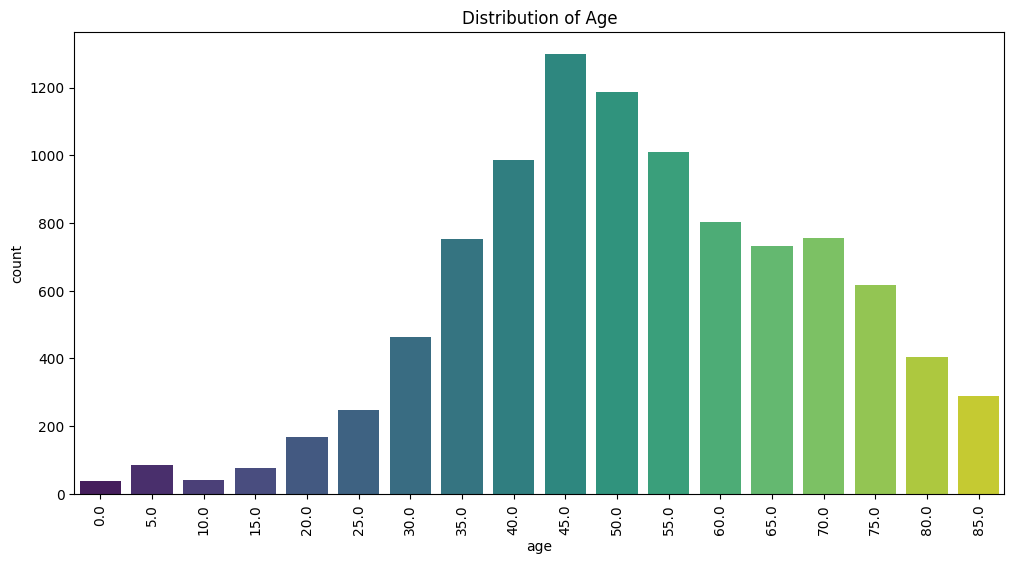

In [ ]:
#Age Distribution
plt.figure(figsize=(12,6))
sns.countplot(data=metadata ,x='age',palette='viridis')
plt.title('Distribution of Age')
plt.xticks(rotation=90)

plt.show()

Text(0.5, 1.0, 'Gender Distribution')

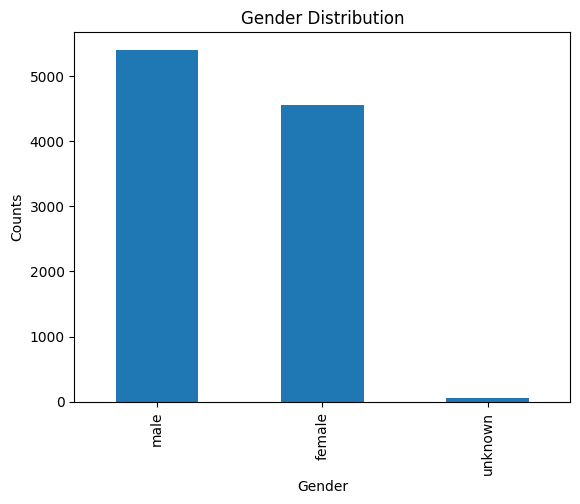

In [ ]:
# Gender Distribution
metadata['sex'].value_counts().plot(kind='bar')
plt.xlabel('Gender')
plt.ylabel('Counts')
plt.title('Gender Distribution')

                                       file_path  file_exists
0  /content/HAM10000_Images/bkl/ISIC_0027419.jpg         True
1  /content/HAM10000_Images/bkl/ISIC_0025030.jpg         True
2  /content/HAM10000_Images/bkl/ISIC_0026769.jpg         True
3  /content/HAM10000_Images/bkl/ISIC_0025661.jpg         True
4  /content/HAM10000_Images/bkl/ISIC_0031633.jpg         True


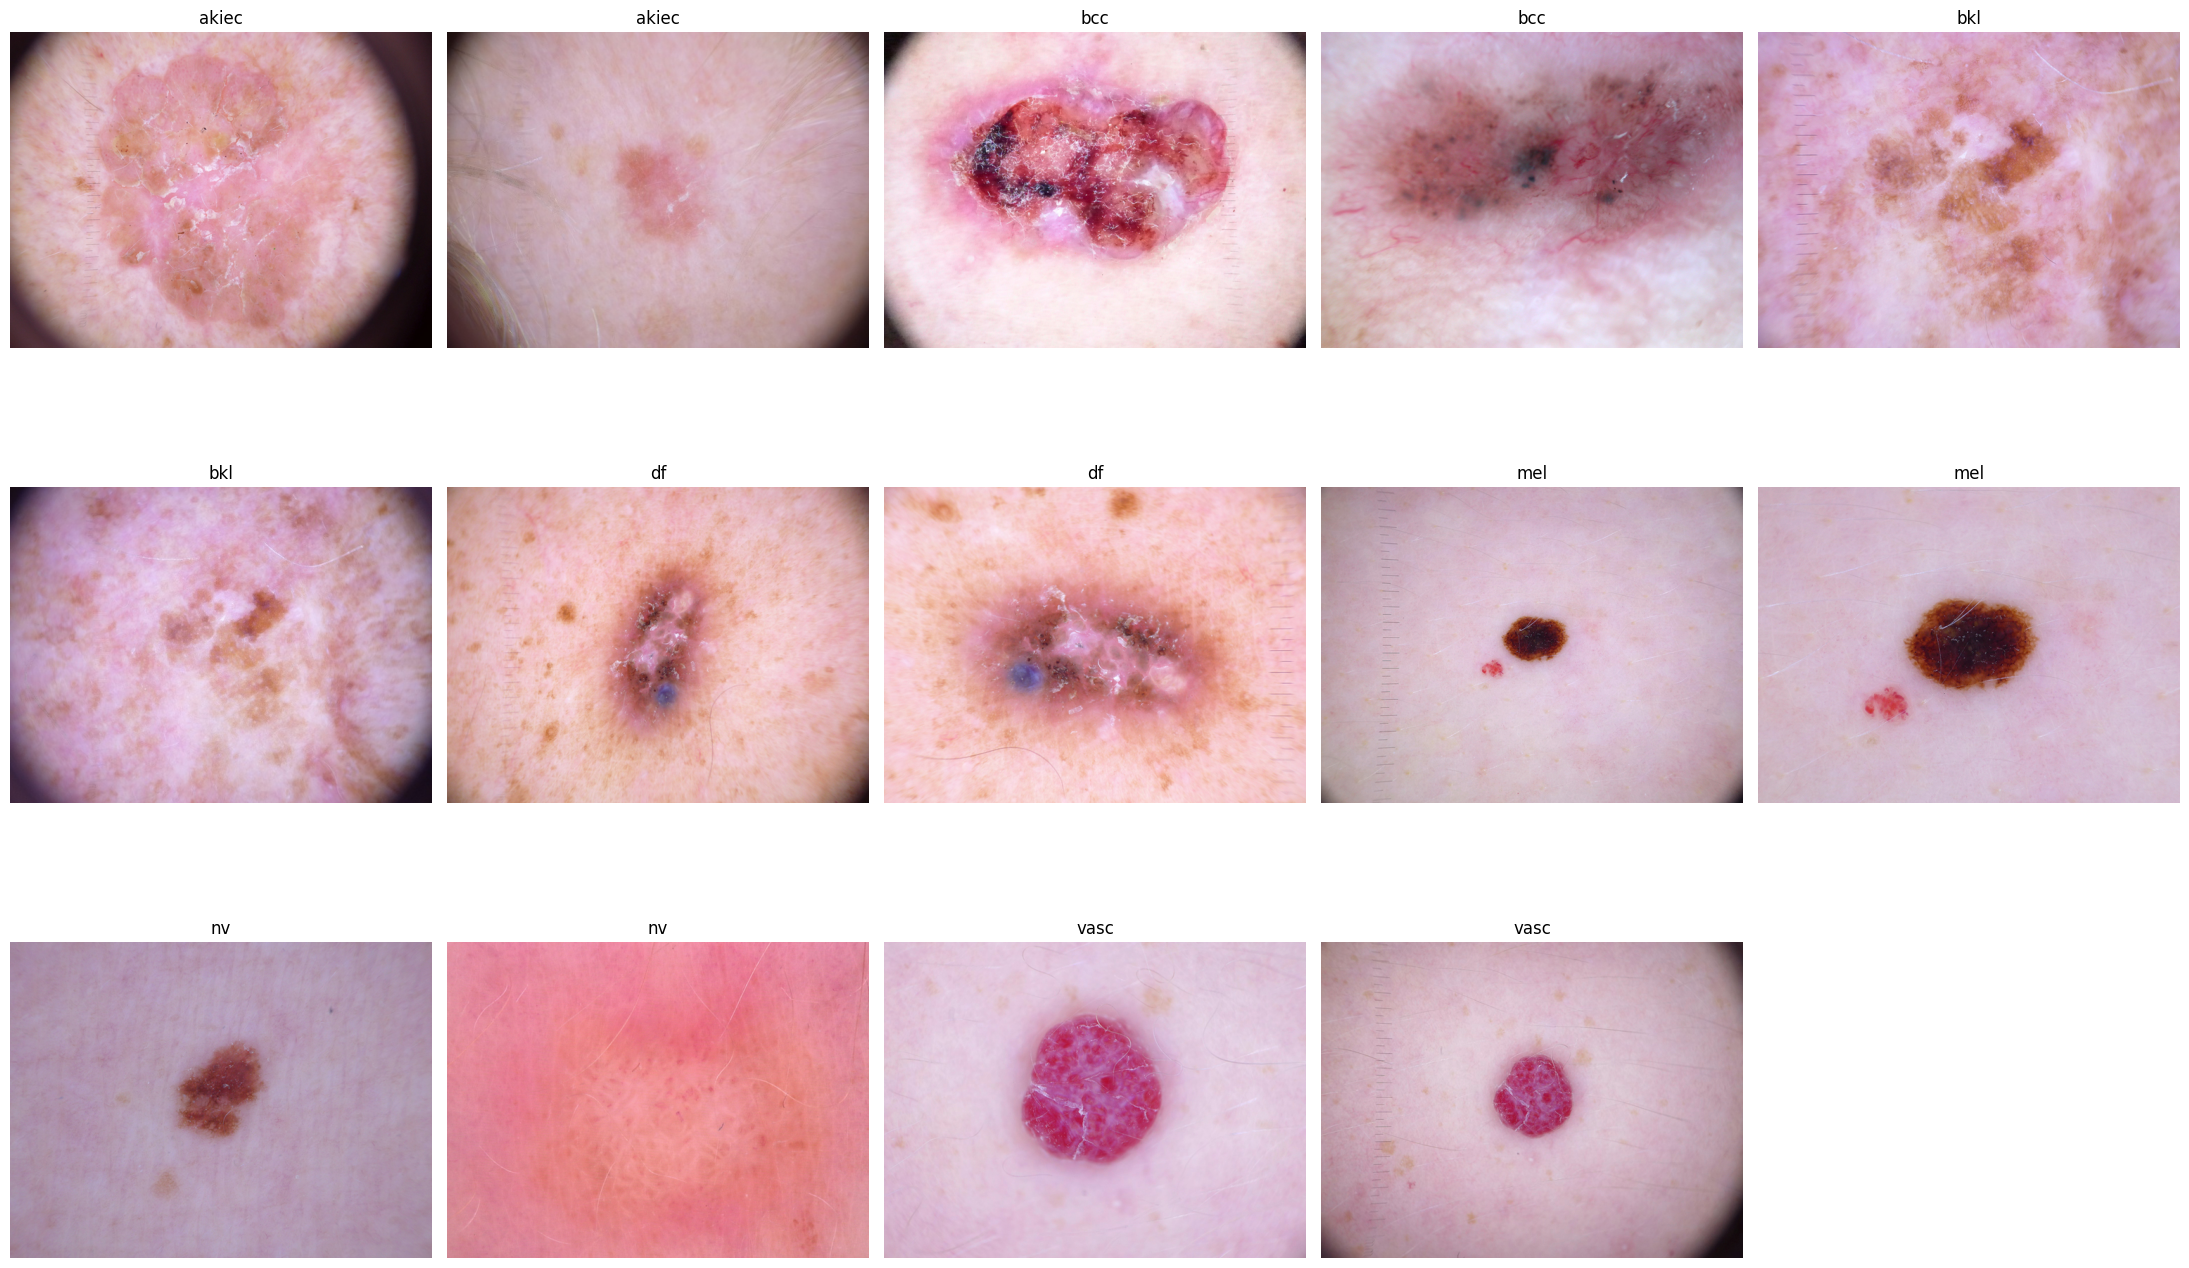

In [ ]:
# Displaying 2 images for each label

# Prepare file paths
metadata['file_path'] = metadata.apply(
    lambda row: os.path.join(images_path, row['dx'], f"{row['image_id']}.jpg"), axis=1
)

# Check if the file paths exist
metadata['file_exists'] = metadata['file_path'].apply(os.path.exists)
print(metadata[['file_path', 'file_exists']].head())


# Group the metadata to extract two samples per label
sample_data = metadata.groupby('dx').apply(lambda df: df.iloc[:2]).reset_index(drop=True)

# Display the images with their labels
plt.figure(figsize=(22, 32))
for i in range(len(sample_data)):
    img_path = sample_data['file_path'].iloc[i]
    img_label = sample_data['dx'].iloc[i]

    # Open and display the image
    img = Image.open(img_path)
    plt.subplot(7, 5, i + 1)
    plt.imshow(img)
    plt.title(img_label)
    plt.axis("off")

plt.tight_layout()
plt.show()


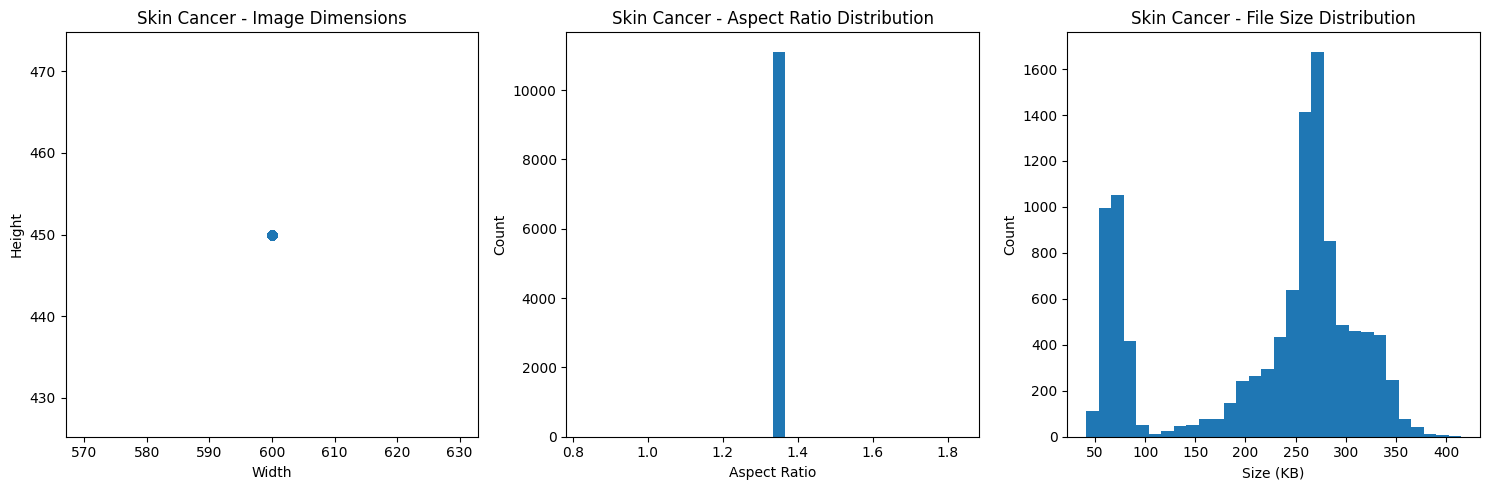

In [ ]:
# Image Properties
plt.figure(figsize=(15, 5))

# Image dimensions
plt.subplot(1, 3, 1)
sizes = np.array(cancer_stats['image_sizes'])
plt.scatter(sizes[:, 1], sizes[:, 0], alpha=0.5)
plt.title('Skin Cancer - Image Dimensions')
plt.xlabel('Width')
plt.ylabel('Height')

# Aspect ratios
plt.subplot(1, 3, 2)
plt.hist(cancer_stats['aspect_ratios'], bins=30)
plt.title('Skin Cancer - Aspect Ratio Distribution')
plt.xlabel('Aspect Ratio')
plt.ylabel('Count')

# File sizes
plt.subplot(1, 3, 3)
plt.hist(cancer_stats['file_sizes'], bins=30)
plt.title('Skin Cancer - File Size Distribution')
plt.xlabel('Size (KB)')
plt.ylabel('Count')

plt.tight_layout()
plt.show()
plt.close()

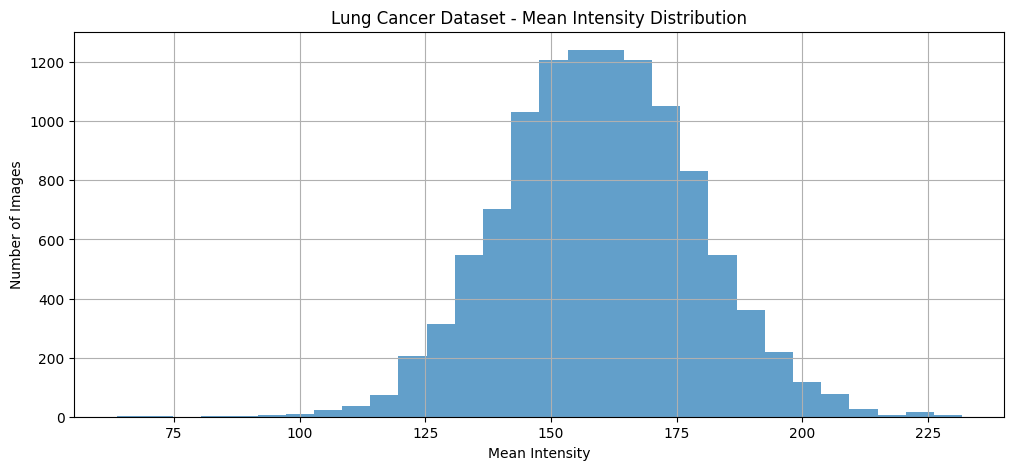

In [ ]:
# Distribution of Mean Intensities
plt.figure(figsize=(12, 5))
plt.hist(cancer_stats['mean_intensities'], bins=30, alpha=0.7)
plt.title('Lung Cancer Dataset - Mean Intensity Distribution')
plt.xlabel('Mean Intensity')
plt.ylabel('Number of Images')
plt.grid(True)
plt.show()
plt.close()

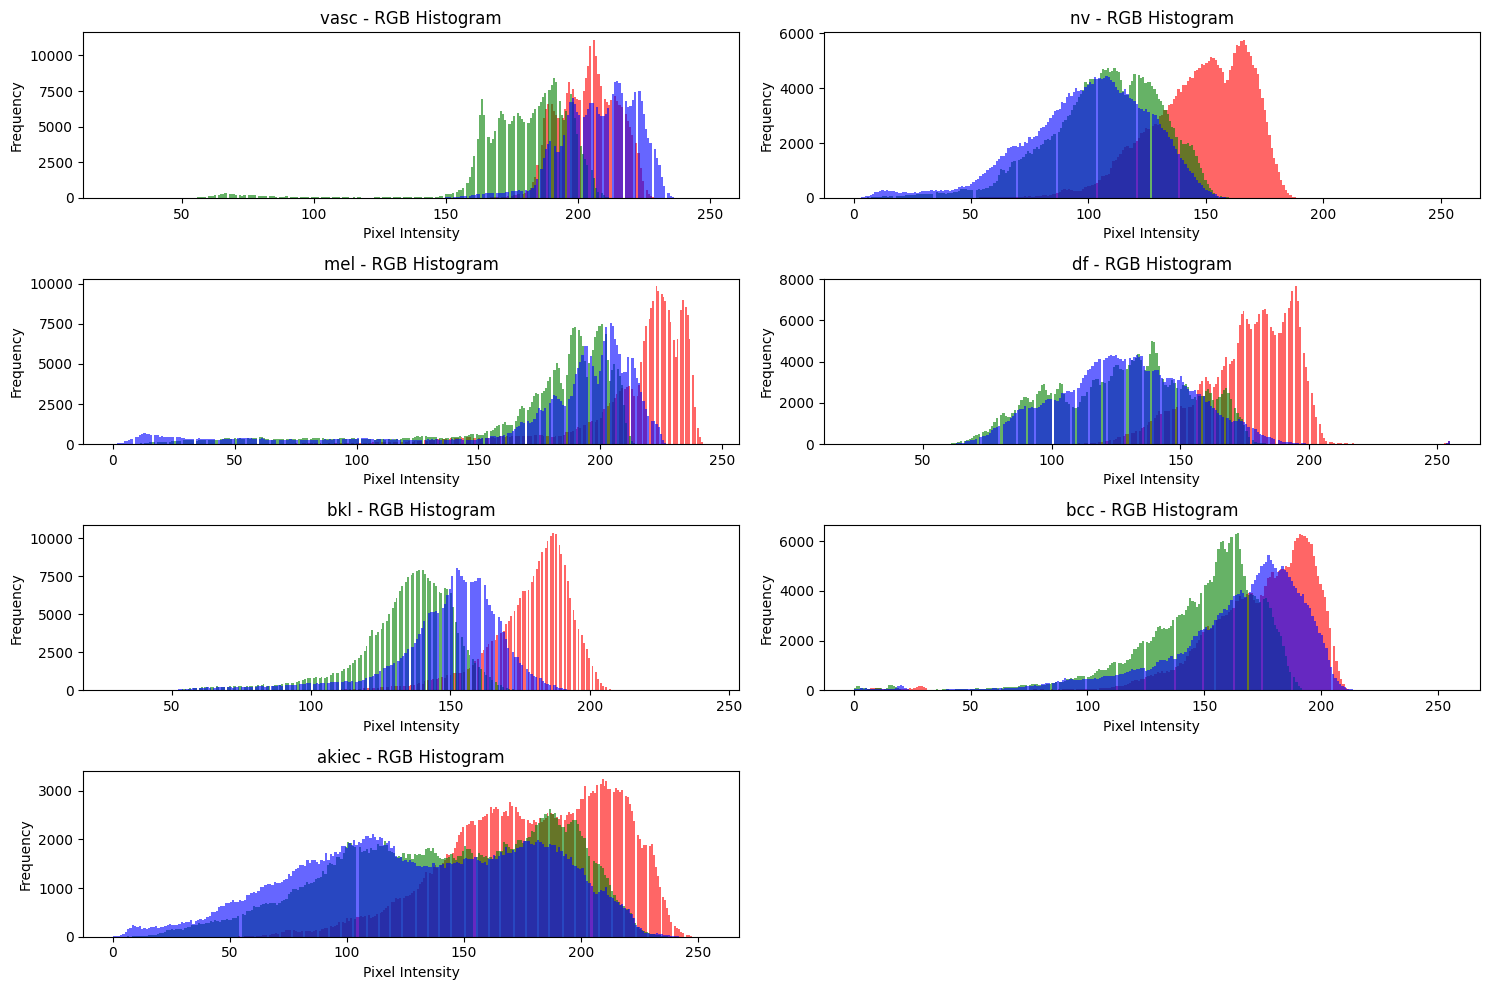

In [ ]:
rows, cols = 4, 2

# Create subplots
fig, axes = plt.subplots(rows, cols, figsize=(15, 10))

# Flatten axes array for easier iteration
axes = axes.flatten()

# Plot each histogram
for i, (class_name, img) in enumerate(cancer_samples.items()):
    ax = axes[i]
    for channel, color in zip(range(4), ['r', 'g', 'b', 'k' ]):
        ax.hist(img[:, :, channel].ravel(), bins=256, color=color, alpha=0.6)
    ax.set_title(f'{class_name} - RGB Histogram')
    ax.set_xlabel('Pixel Intensity')
    ax.set_ylabel('Frequency')
    ax.grid(False)

# Hide unused subplots
for j in range(len(cancer_samples), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

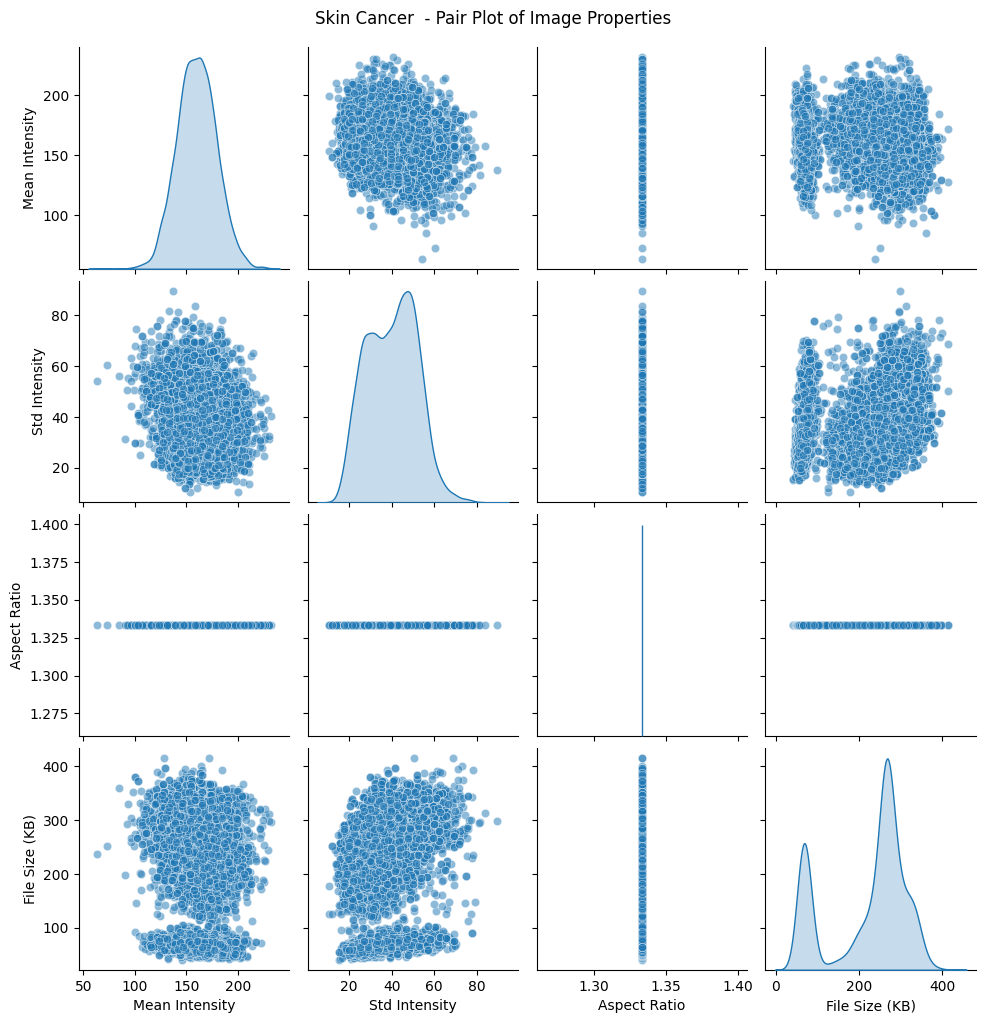

In [ ]:
# Pair Plot of Lung Image Properties
dataframe = pd.DataFrame({
    'Mean Intensity': cancer_stats['mean_intensities'],
    'Std Intensity': cancer_stats['std_intensities'],
    'Aspect Ratio': cancer_stats['aspect_ratios'],
    'File Size (KB)': cancer_stats['file_sizes']
})
sns.pairplot(dataframe, diag_kind='kde', plot_kws={'alpha': 0.5})
plt.suptitle('Skin Cancer  - Pair Plot of Image Properties', y=1.02)
plt.show()
plt.close()

## Preprocessing

In [ ]:
img_dir='/content/HAM10000_Images/bcc'
img_files = os.listdir(img_dir)

# Ensure the directory contains images
if not img_files:
    print("No images found in the directory!")
else:
    # Path to the first image in the directory
    img_path = os.path.join(img_dir, img_files[0])

    # Read the image
    img = cv2.imread(img_path)

    # Check if the image was read successfully
    if img is None:
        print(f"Failed to read image: {img_path}")
    else:
        # Print width and height of the image
        print('width: {}\nheight: {}'.format(img.shape[1], img.shape[0]))

width: 600
height: 450


In [ ]:
# Data Augmentation for Minority Classes
datagen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)


In [ ]:

d_paths=[
    '/content/HAM10000_Images/akiec',
    '/content/HAM10000_Images/bcc',
    '/content/HAM10000_Images/bkl',
    '/content/HAM10000_Images/df',
    '/content/HAM10000_Images/mel',
    '/content/HAM10000_Images/vasc'
]

In [ ]:
# Augment Images for Minority Classes
for d_path in d_paths:
    class_name = os.path.basename(d_path)
    print(f"Augmenting class: {class_name}")
    for img_name in os.listdir(d_path):
        img_path = os.path.join(d_path, img_name)
        img_array = np.expand_dims(cv2.imread(img_path), axis=0)
        for i, transformed_img in enumerate(datagen.flow(img_array, batch_size=1)):
            if i >= 10:  # Generate 10 augmented images per original
                break
            augmented_path = f"/augmented/{class_name}/{img_name.split('.')[0]}_aug_{i}.jpg"
            os.makedirs(f"/augmented/{class_name}", exist_ok=True)
            cv2.imwrite(augmented_path, transformed_img[0])

Augmenting class: akiec
Augmenting class: bcc
Augmenting class: bkl
Augmenting class: df
Augmenting class: mel
Augmenting class: vasc


In [44]:

# Load Dataset (Including Augmented Data)
train_ds = tf.keras.utils.image_dataset_from_directory(
    '/augmented',
    validation_split=0.2,
    subset="training",
    seed=42,
    image_size=(28, 28),
    batch_size=32,
)

validation_ds = tf.keras.utils.image_dataset_from_directory(
    '/augmented',
    validation_split=0.2,
    subset="validation",
    seed=42,
    image_size=(28, 28),
    batch_size=32,
)

test_ds = tf.keras.utils.image_dataset_from_directory(
    '/augmented',
    seed=42,
    image_size=(28, 28),
    batch_size=32
)




Found 35242 files belonging to 7 classes.
Using 28194 files for training.
Found 35242 files belonging to 7 classes.
Using 7048 files for validation.
Found 35242 files belonging to 7 classes.


In [47]:
# Function to separate features (X) and labels (y)
def extract_features_and_labels(dataset):
    X = []
    y = []
    for images, labels in dataset:
        X.append(images.numpy())
        y.append(labels.numpy())
    return tf.concat(X, axis=0), tf.concat(y, axis=0)

# Separate features and labels for train, validation, and test sets
X_train, Y_train = extract_features_and_labels(train_ds)
X_val, y_val = extract_features_and_labels(validation_ds)
X_test, Y_test = extract_features_and_labels(test_ds)

In [45]:
from sklearn.utils.class_weight import compute_class_weight
# Compute Class Weights
y_true = []
for _, labels in train_ds:
    y_true.extend(labels.numpy())

class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_true),
    y=y_true
)
class_weights_dict = {i: weight for i, weight in enumerate(class_weights)}


In [48]:
def normalize_images(images):
  return images / 255.0

# Normalize the image datasets
X_train_normalized = normalize_images(X_train)
X_val_normalized = normalize_images(X_val)
X_test_normalized = normalize_images(X_test)


In [49]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
validation_ds = validation_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

## CNN Model Training

In [ ]:
model = Sequential()
# The input shape of the first layer needs to be modified to match the training data which has a shape of (28,28,3).
model.add(Conv2D(16, kernel_size = (3,3), input_shape = (28,28,3), activation = 'relu', padding = 'same')) #This line has been changed.
model.add(Conv2D(32, kernel_size = (3,3), activation = 'relu'))
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Conv2D(32, kernel_size = (3,3), activation = 'relu', padding = 'same'))
model.add(Conv2D(64, kernel_size = (3,3), activation = 'relu'))
model.add(MaxPooling2D(pool_size = (2,2), padding = 'same'))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(len(class_weights), activation='softmax'))
model.summary()



Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 28, 28, 16)          │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 26, 26, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 13, 13, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 13, 13, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 11, 11, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 6, 6, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 2304)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │         147,520 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 7)                   │             231 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 182,663 (713.53 KB)

 Trainable params: 182,663 (713.53 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='bestmodels.keras',
    monitor='val_acc',
    mode='max',
    verbose=1
)

X_train = X_train.reshape(-1, 28, 28, 3)
X_test = X_test.reshape(-1, 28, 28, 3)

In [ ]:
model.compile(loss = 'sparse_categorical_crossentropy',
             optimizer = 'adam',
              metrics = ['accuracy'])
history = model.fit(X_train,
                    Y_train,
                    validation_split=0.2,
                    batch_size = 128,
                    class_weight=class_weights_dict,
                    epochs = 20,
                    callbacks=[callback, tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)])

Epoch 1/20
239/239 ━━━━━━━━━━━━━━━━━━━━ 0s 255ms/step - accuracy: 0.9533 - loss: 0.1352
Epoch 1: saving model to bestmodels.keras
239/239 ━━━━━━━━━━━━━━━━━━━━ 67s 271ms/step - accuracy: 0.9533 - loss: 0.1351 - val_accuracy: 0.9567 - val_loss: 0.1408
Epoch 2/20
239/239 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step - accuracy: 0.9737 - loss: 0.0748
Epoch 2: saving model to bestmodels.keras
239/239 ━━━━━━━━━━━━━━━━━━━━ 77s 252ms/step - accuracy: 0.9737 - loss: 0.0748 - val_accuracy: 0.9497 - val_loss: 0.1678
Epoch 3/20
239/239 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step - accuracy: 0.9787 - loss: 0.0642
Epoch 3: saving model to bestmodels.keras
239/239 ━━━━━━━━━━━━━━━━━━━━ 81s 250ms/step - accuracy: 0.9787 - loss: 0.0642 - val_accuracy: 0.9632 - val_loss: 0.1295
Epoch 4/20
239/239 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step - accuracy: 0.9828 - loss: 0.0499
Epoch 4: saving model to bestmodels.keras
239/239 ━━━━━━━━━━━━━━━━━━━━ 60s 249ms/step - accuracy: 0.9828 - loss: 0.0500 - val_accuracy: 0.9527 - val_loss: 0.1653


## Model Evaluation

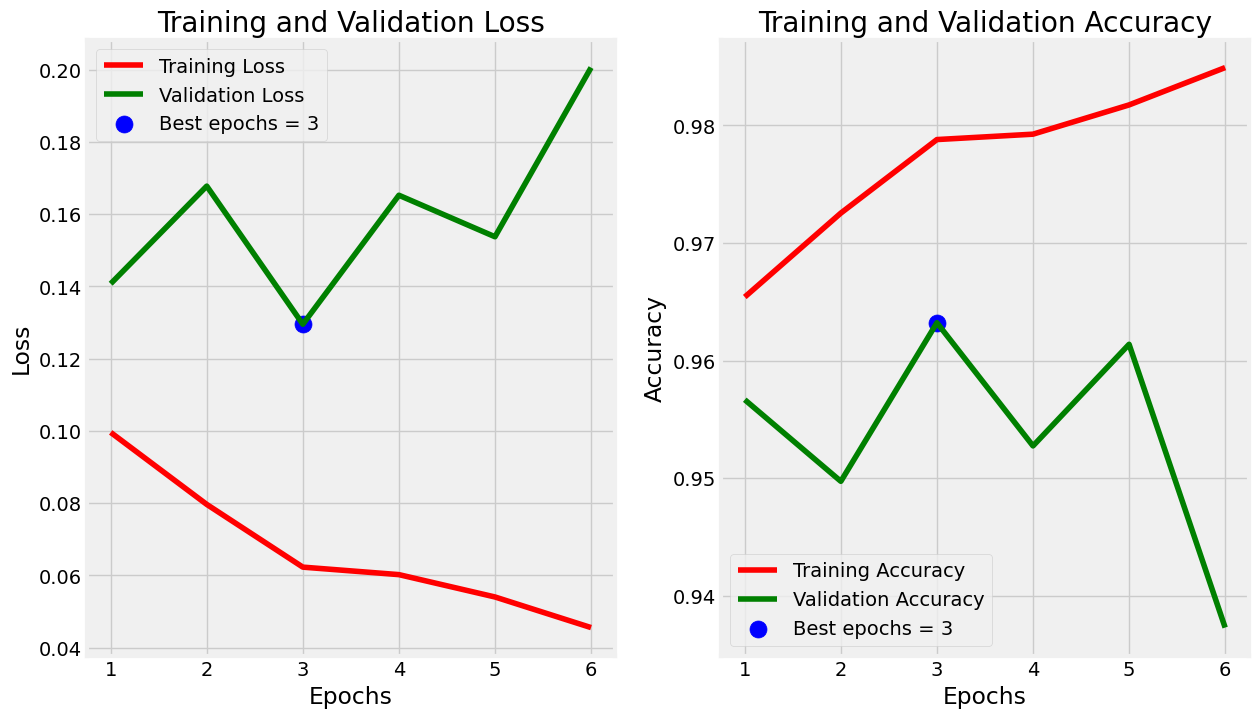

In [ ]:
train_acc = history.history['accuracy']
train_loss = history.history['loss']

val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]

index_acc = np.argmax(val_acc)
val_highest = val_acc[index_acc]

Epochs = [i+1 for i in range(len(train_acc))]

loss_label = f'Best epochs = {str(index_loss +1)}'
acc_label = f'Best epochs = {str(index_acc + 1)}'
plt.figure(figsize= (15,8))
plt.style.use('fivethirtyeight')

plt.subplot(1,2,1)
plt.plot(Epochs , train_loss , 'r' , label = 'Training Loss')
plt.plot(Epochs , val_loss , 'g' , label = 'Validation Loss')
plt.scatter(index_loss + 1 , val_lowest , s = 150 , c = 'blue',label = loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(Epochs , train_acc , 'r' , label = 'Training Accuracy')
plt.plot(Epochs , val_acc , 'g' , label = 'Validation Accuracy')
plt.scatter(index_acc + 1 , val_highest , s = 150 , c = 'blue',label = acc_label)
plt.title('Training and Validation Accuracy')

plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout
plt.show()


In [ ]:
loss, acc = model.evaluate(X_test, Y_test, verbose=20)
print("Loss: ", loss)
print(f"Test Accuracy: {acc * 100:.2f}%")

Loss:  0.18676236271858215
Test Accuracy: 94.17%


299/299 ━━━━━━━━━━━━━━━━━━━━ 10s 32ms/step
              precision    recall  f1-score   support

          nv       0.97      0.98      0.97      1367
         mel       0.96      0.96      0.96      1350
         bkl       0.89      0.94      0.92      1317
         bcc       0.97      1.00      0.98      1352
       akiec       0.87      0.84      0.86      1401
        vasc       0.99      1.00      1.00      1347
          df       0.93      0.87      0.90      1414

    accuracy                           0.94      9548
   macro avg       0.94      0.94      0.94      9548
weighted avg       0.94      0.94      0.94      9548



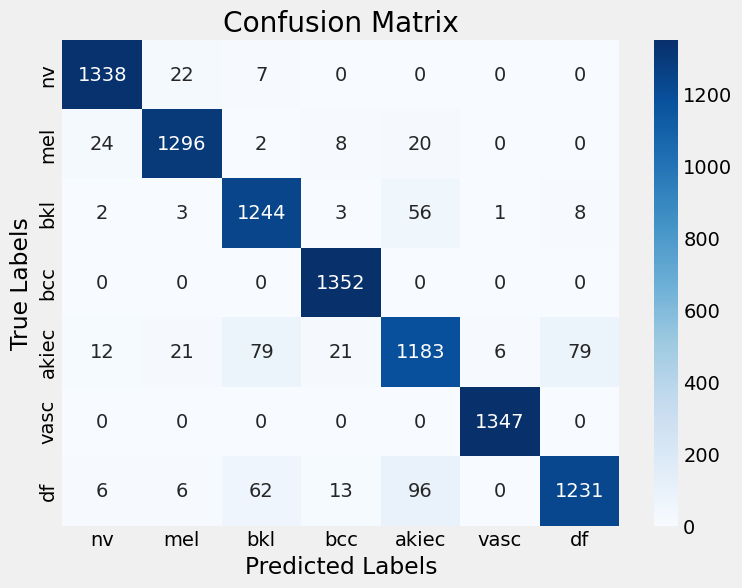

In [ ]:

y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)


class_labels=['nv','mel','bkl','bcc','akiec','vasc','df']
# Generate the classification report
print(classification_report(Y_test, y_pred_classes, target_names=class_labels))


# Generate the confusion matrix
cm = confusion_matrix(Y_test, y_pred_classes)

# Plot the confusion matrix with class labels
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()